In [2]:
from src.loader import load_images, DataSampler

#### Load images 

In [3]:
! ls data

attributes.pth			 img_align_celeba
CelebA-20180522T203437Z-015.zip  img_align_celeba.zip
celeba_64.hdf5			 input_data_eda.ipynb
cifar-10-python.tar.gz		 list_attr_celeba.txt
images_256_256_20000.pth	 mona-v3-inference.csv
images_256_256.pth		 preprocess.py


In [4]:
images_filename = 'images_%i_%i_20000.pth'

In [5]:
images_filename = images_filename % (256, 256)

In [6]:
import torch
images = torch.load(f'data/{images_filename}')

In [7]:
attributes = torch.load('data/attributes.pth')

In [8]:
attributes.keys()

dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'])

In [9]:
AVAILABLE_ATTR = [
    "5_o_Clock_Shadow", "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", "Bald",
    "Bangs", "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", "Blurry", "Brown_Hair",
    "Bushy_Eyebrows", "Chubby", "Double_Chin", "Eyeglasses", "Goatee", "Gray_Hair",
    "Heavy_Makeup", "High_Cheekbones", "Male", "Mouth_Slightly_Open", "Mustache",
    "Narrow_Eyes", "No_Beard", "Oval_Face", "Pale_Skin", "Pointy_Nose",
    "Receding_Hairline", "Rosy_Cheeks", "Sideburns", "Smiling", "Straight_Hair",
    "Wavy_Hair", "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick",
    "Wearing_Necklace", "Wearing_Necktie", "Young"
]

In [10]:
def attr_flag(s):
    """
    Parse attributes parameters.
    """
    if s == "*":
        return s
    attr = s.split(',')
    assert len(attr) == len(set(attr))
    attributes = []
    for x in attr:
        if '.' not in x:
            attributes.append((x, 2))
        else:
            split = x.split('.')
            assert len(split) == 2 and len(split[0]) > 0
            assert split[1].isdigit() and int(split[1]) >= 2
            attributes.append((split[0], int(split[1])))
    return sorted(attributes, key=lambda x: (x[1], x[0]))

In [11]:
input_attrs = attr_flag(','.join(AVAILABLE_ATTR))

In [12]:
input_attrs, len(input_attrs)

([('5_o_Clock_Shadow', 2),
  ('Arched_Eyebrows', 2),
  ('Attractive', 2),
  ('Bags_Under_Eyes', 2),
  ('Bald', 2),
  ('Bangs', 2),
  ('Big_Lips', 2),
  ('Big_Nose', 2),
  ('Black_Hair', 2),
  ('Blond_Hair', 2),
  ('Blurry', 2),
  ('Brown_Hair', 2),
  ('Bushy_Eyebrows', 2),
  ('Chubby', 2),
  ('Double_Chin', 2),
  ('Eyeglasses', 2),
  ('Goatee', 2),
  ('Gray_Hair', 2),
  ('Heavy_Makeup', 2),
  ('High_Cheekbones', 2),
  ('Male', 2),
  ('Mouth_Slightly_Open', 2),
  ('Mustache', 2),
  ('Narrow_Eyes', 2),
  ('No_Beard', 2),
  ('Oval_Face', 2),
  ('Pale_Skin', 2),
  ('Pointy_Nose', 2),
  ('Receding_Hairline', 2),
  ('Rosy_Cheeks', 2),
  ('Sideburns', 2),
  ('Smiling', 2),
  ('Straight_Hair', 2),
  ('Wavy_Hair', 2),
  ('Wearing_Earrings', 2),
  ('Wearing_Hat', 2),
  ('Wearing_Lipstick', 2),
  ('Wearing_Necklace', 2),
  ('Wearing_Necktie', 2),
  ('Young', 2)],
 40)

In [13]:
import numpy as np
attrs = []
for name, n_cat in input_attrs:
    for i in range(n_cat):
        attrs.append(torch.FloatTensor((attributes[name] == i).astype(np.float32)))

In [14]:
attrs[0].shape

torch.Size([202599])

In [15]:
attributes = torch.cat([x.unsqueeze(1) for x in attrs], 1)

In [16]:
attributes.shape

torch.Size([202599, 80])

### Implementation





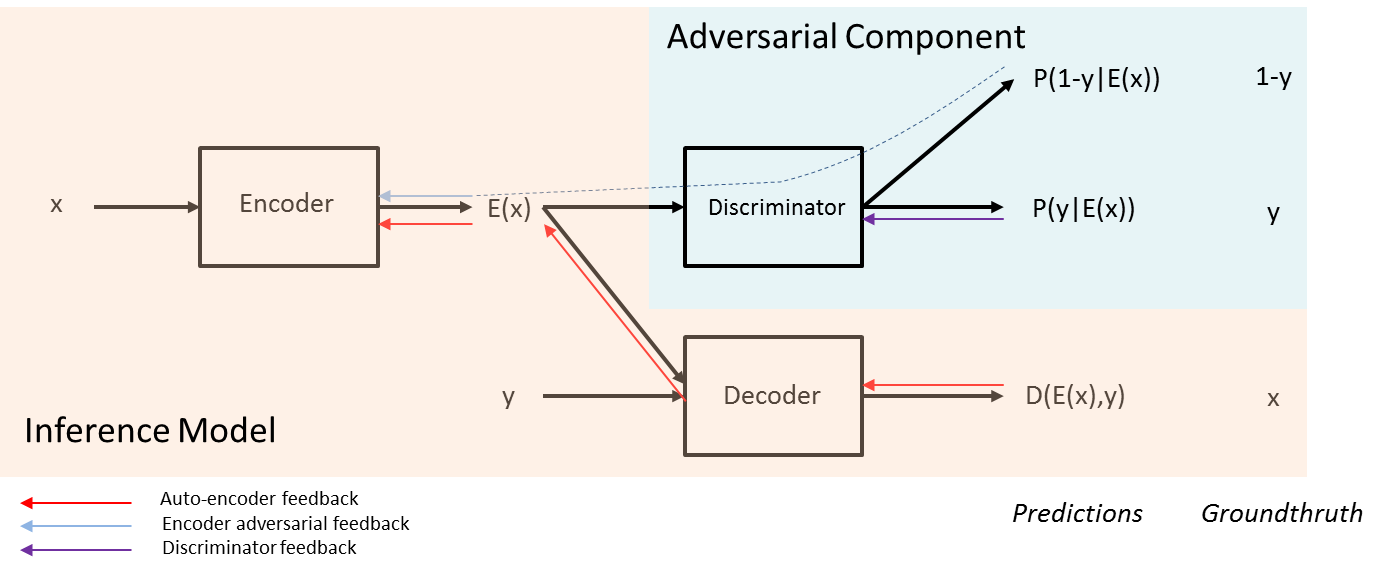

In [41]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "images/v3.png")

Let $C_k$ be a Convolution-BatchNorm-ReLU layer with $k$ filters. Convolutions use kernel of size $4 X 4$, with a stride of 2, and a padding of 1, so that
each layer of the encoder divides the size of its input by 2. We use leaky-ReLUs with a slope of 0.2
in the encoder, and simple ReLUs in the decod

### Autoencoder

In [18]:
from torch import nn

In [20]:
def build_layers(img_sz, img_fm, init_fm, max_fm, n_layers, n_attr, n_skip,
                 deconv_method, instance_norm, enc_dropout, dec_dropout):
    """
    Build auto-encoder layers.
    """
    assert init_fm <= max_fm
    assert n_skip <= n_layers - 1
    assert np.log2(img_sz).is_integer()
    assert n_layers <= int(np.log2(img_sz))
    assert type(instance_norm) is bool
    assert 0 <= enc_dropout < 1
    assert 0 <= dec_dropout < 1
    norm_fn = nn.InstanceNorm2d if instance_norm else nn.BatchNorm2d

    enc_layers = []
    dec_layers = []

    n_in = img_fm
    n_out = init_fm

    for i in range(n_layers):
        enc_layer = []
        dec_layer = []
        skip_connection = n_layers - (n_skip + 1) <= i < n_layers - 1
        n_dec_in = n_out + n_attr + (n_out if skip_connection else 0)
        n_dec_out = n_in

        # encoder layer
        enc_layer.append(nn.Conv2d(n_in, n_out, 4, 2, 1))
        if i > 0:
            enc_layer.append(norm_fn(n_out, affine=True))
        enc_layer.append(nn.LeakyReLU(0.2, inplace=True))
        if enc_dropout > 0:
            enc_layer.append(nn.Dropout(enc_dropout))

        # decoder layer
        if deconv_method == 'upsampling':
            dec_layer.append(nn.UpsamplingNearest2d(scale_factor=2))
            dec_layer.append(nn.Conv2d(n_dec_in, n_dec_out, 3, 1, 1))
        elif deconv_method == 'convtranspose':
            dec_layer.append(nn.ConvTranspose2d(n_dec_in, n_dec_out, 4, 2, 1, bias=False))
        else:
            assert deconv_method == 'pixelshuffle'
            dec_layer.append(nn.Conv2d(n_dec_in, n_dec_out * 4, 3, 1, 1))
            dec_layer.append(nn.PixelShuffle(2))
        if i > 0:
            dec_layer.append(norm_fn(n_dec_out, affine=True))
            if dec_dropout > 0 and i >= n_layers - 3:
                dec_layer.append(nn.Dropout(dec_dropout))
            dec_layer.append(nn.ReLU(inplace=True))
        else:
            dec_layer.append(nn.Tanh())

        # update
        n_in = n_out
        n_out = min(2 * n_out, max_fm)
        enc_layers.append(nn.Sequential(*enc_layer))
        dec_layers.insert(0, nn.Sequential(*dec_layer))

    return enc_layers, dec_layers

In [27]:
class AutoEncoder(nn.Module):
    def __init__(self, img_sz, img_fz, instance_norm, init_fm, max_fm, n_layers, n_skip, deconv_method, dec_dropout, attr, n_attr):
        super(AutoEncoder, self).__init__()

        self.img_sz = img_sz #Image sizes (images have to be squared)
        self.img_fm = img_fm #Number of feature maps (3 for RGB)
        self.instance_norm = instance_norm # Use instance normalization instead of batch normalization
        self.init_fm = init_fm #Number of initial filters in the encoder
        self.max_fm = max_fm #Number maximum of filters in the autoencoder
        self.n_layers = n_layers #Number of layers in the encoder / decoder
        self.n_skip = n_skip #Number of skip connections
        self.deconv_method = deconv_method # Deconvolution method (default : convtranspose)
        self.dropout = dec_dropout #Dropout in the decoder
        self.attr = attr
        self.n_attr = n_attr

        enc_layers, dec_layers = build_layers(self.img_sz, self.img_fm, self.init_fm,
                                              self.max_fm, self.n_layers, self.n_attr,
                                              self.n_skip, self.deconv_method,
                                              self.instance_norm, 0, self.dropout)
        self.enc_layers = nn.ModuleList(enc_layers)
        self.dec_layers = nn.ModuleList(dec_layers)

    def encode(self, x):
        assert x.size()[1:] == (self.img_fm, self.img_sz, self.img_sz)

        enc_outputs = [x]
        for layer in self.enc_layers:
            enc_outputs.append(layer(enc_outputs[-1]))

        assert len(enc_outputs) == self.n_layers + 1
        return enc_outputs

    def decode(self, enc_outputs, y):
        bs = enc_outputs[0].size(0)
        assert len(enc_outputs) == self.n_layers + 1
        assert y.size() == (bs, self.n_attr)

        dec_outputs = [enc_outputs[-1]]
        y = y.unsqueeze(2).unsqueeze(3)
        for i, layer in enumerate(self.dec_layers):
            size = dec_outputs[-1].size(2)
            # attributes
            input = [dec_outputs[-1], y.expand(bs, self.n_attr, size, size)]
            # skip connection
            if 0 < i <= self.n_skip:
                input.append(enc_outputs[-1 - i])
            input = torch.cat(input, 1)
            dec_outputs.append(layer(input))

        assert len(dec_outputs) == self.n_layers + 1
        assert dec_outputs[-1].size() == (bs, self.img_fm, self.img_sz, self.img_sz)
        return dec_outputs

    def forward(self, x, y):
        enc_outputs = self.encode(x)
        dec_outputs = self.decode(enc_outputs, y)
        return enc_outputs, dec_outputs

In [29]:
input_attrs = [('Male', 2), ('Smiling', 2)]
#instance_norm, init_fm, max_fm, n_layers, n_skip, deconv_method, dec_dropout, attr, n_attr

img_sz= 256
img_fm=3 
instance_norm = False
init_fm = 32
max_fm = 512
n_layers = 6
n_skip = 0 
deconv_method = 'convtranspose'
dec_dropout = 0.0
attr = input_attrs
n_attr = len(input_attrs)
ae = AutoEncoder(img_sz, img_fm, instance_norm, init_fm, max_fm, n_layers, n_skip,deconv_method, dec_dropout, attr, n_attr).cuda()

In [32]:
ae

AutoEncoder(
  (enc_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4

In [37]:
class LatentDiscriminator(nn.Module):

    def __init__(self, img_sz, img_fz, instance_norm, init_fm, max_fm, n_layers, n_skip, deconv_method, dec_dropout, attr, n_attr, hid_dim):
        super(LatentDiscriminator, self).__init__()

        
        self.img_sz = img_sz #Image sizes (images have to be squared)
        self.img_fm = img_fm #Number of feature maps (3 for RGB)
        self.instance_norm = instance_norm # Use instance normalization instead of batch normalization
        self.init_fm = init_fm #Number of initial filters in the encoder
        self.max_fm = max_fm #Number maximum of filters in the autoencoder
        self.n_layers = n_layers #Number of layers in the encoder / decoder
        self.n_skip = n_skip #Number of skip connections
        self.deconv_method = deconv_method # Deconvolution method (default : convtranspose)
        self.dropout = dec_dropout #Dropout in the decoder
        self.attr = attr
        self.n_attr = n_attr
        self.hid_dim = hid_dim
        
        self.n_dis_layers = int(np.log2(self.img_sz))
        self.conv_in_sz = self.img_sz / (2 ** (self.n_layers - self.n_skip))
        self.conv_in_fm = min(self.init_fm * (2 ** (self.n_layers - self.n_skip - 1)), self.max_fm)
        self.conv_out_fm = min(self.init_fm * (2 ** (self.n_dis_layers - 1)), self.max_fm)

        # discriminator layers are identical to encoder, but convolve until size 1
        enc_layers, _ = build_layers(self.img_sz, self.img_fm, self.init_fm, self.max_fm,
                                     self.n_dis_layers, self.n_attr, 0, 'convtranspose',
                                     False, self.dropout, 0)

        self.conv_layers = nn.Sequential(*(enc_layers[self.n_layers - self.n_skip:]))
        self.proj_layers = nn.Sequential(
            nn.Linear(self.conv_out_fm, self.hid_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.hid_dim, self.n_attr)
        )

    def forward(self, x):
        assert x.size()[1:] == (self.conv_in_fm, self.conv_in_sz, self.conv_in_sz)
        conv_output = self.conv_layers(x)
        assert conv_output.size() == (x.size(0), self.conv_out_fm, 1, 1)
        return self.proj_layers(conv_output.view(x.size(0), self.conv_out_fm))

#### Latent Discriminator

In [44]:
hid_dim = 512

In [39]:
lat_dis = LatentDiscriminator(img_sz, img_fm, instance_norm, init_fm, max_fm, n_layers, n_skip,deconv_method, dec_dropout, attr, n_attr, hid_dim).cuda()

In [40]:
lat_dis

LatentDiscriminator(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): Sequential(
      (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (proj_layers): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

#### Patch Discriminator

In [49]:
class PatchDiscriminator(nn.Module):
    def __init__(self, img_sz, img_fm, init_fm, max_fm):
        super(PatchDiscriminator, self).__init__()

        self.img_sz = img_sz
        self.img_fm = img_fm
        self.init_fm = init_fm
        self.max_fm = max_fm
        self.n_patch_dis_layers = 3

        layers = []
        layers.append(nn.Conv2d(self.img_fm, self.init_fm, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.2, True))

        n_in = self.init_fm
        n_out = min(2 * n_in, self.max_fm)

        for n in range(self.n_patch_dis_layers):
            stride = 1 if n == self.n_patch_dis_layers - 1 else 2
            layers.append(nn.Conv2d(n_in, n_out, kernel_size=4, stride=stride, padding=1))
            layers.append(nn.BatchNorm2d(n_out))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if n < self.n_patch_dis_layers - 1:
                n_in = n_out
                n_out = min(2 * n_out, self.max_fm)

        layers.append(nn.Conv2d(n_out, 1, kernel_size=4, stride=1, padding=1))
        layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        assert x.dim() == 4
        return self.layers(x).view(x.size(0), -1).mean(1).view(x.size(0))


In [50]:
patch_dis = PatchDiscriminator(img_sz, img_fm, init_fm, max_fm).cuda()

### Classifier

In [51]:
class Classifier(nn.Module):

    def __init__(self, img_sz, img_fm, init_fm, max_fm, hid_dim, attr, n_attr):
        super(Classifier, self).__init__()

        self.img_sz = img_sz
        self.img_fm = img_fm
        self.init_fm = init_fm
        self.max_fm = max_fm
        self.hid_dim = hid_dim
        self.attr = attr
        self.n_attr = n_attr

        self.n_clf_layers = int(np.log2(self.img_sz))
        self.conv_out_fm = min(self.init_fm * (2 ** (self.n_clf_layers - 1)), self.max_fm)

        # classifier layers are identical to encoder, but convolve until size 1
        enc_layers, _ = build_layers(self.img_sz, self.img_fm, self.init_fm, self.max_fm,
                                     self.n_clf_layers, self.n_attr, 0, 'convtranspose',
                                     False, 0, 0)

        self.conv_layers = nn.Sequential(*enc_layers)
        self.proj_layers = nn.Sequential(
            nn.Linear(self.conv_out_fm, self.hid_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.hid_dim, self.n_attr)
        )

    def forward(self, x):
        assert x.size()[1:] == (self.img_fm, self.img_sz, self.img_sz)
        conv_output = self.conv_layers(x)
        assert conv_output.size() == (x.size(0), self.conv_out_fm, 1, 1)
        return self.proj_layers(conv_output.view(x.size(0), self.conv_out_fm))

In [52]:
cls = Classifier(img_sz, img_fm, init_fm, max_fm, hid_dim, attr, n_attr).cuda()

### evaluation classifier

In [7]:
import torch

In [8]:
EVAL_CLF_PATH = "models/classifier256.pth"

eval_clf = torch.load(EVAL_CLF_PATH).cuda().eval()

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LeakyReLU' has changed. you can retr

In [9]:
eval_clf

Classifier(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d (3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(0.2, inplace)
    )
    (1): Sequential(
      (0): Conv2d (32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.2, inplace)
    )
    (2): Sequential(
      (0): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.2, inplace)
    )
    (3): Sequential(
      (0): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.2, inplace)
    )
    (4): Sequential(
      (0): Conv2d (256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.2, inplace

In [10]:
class Trainer(object):

    def __init__(self, ae, lat_dis, ptc_dis, clf_dis, data, params):
        """
        Trainer initialization.
        """
        # data / parameters
        self.data = data
        self.params = params

        # modules
        self.ae = ae
        self.lat_dis = lat_dis
        self.ptc_dis = ptc_dis
        self.clf_dis = clf_dis

        # optimizers
        self.ae_optimizer = get_optimizer(ae, params.ae_optimizer)
        logger.info(ae)
        logger.info('%i parameters in the autoencoder. '
                    % sum([p.nelement() for p in ae.parameters()]))
        if params.n_lat_dis:
            logger.info(lat_dis)
            logger.info('%i parameters in the latent discriminator. '
                        % sum([p.nelement() for p in lat_dis.parameters()]))
            self.lat_dis_optimizer = get_optimizer(lat_dis, params.dis_optimizer)
        if params.n_ptc_dis:
            logger.info(ptc_dis)
            logger.info('%i parameters in the patch discriminator. '
                        % sum([p.nelement() for p in ptc_dis.parameters()]))
            self.ptc_dis_optimizer = get_optimizer(ptc_dis, params.dis_optimizer)
        if params.n_clf_dis:
            logger.info(clf_dis)
            logger.info('%i parameters in the classifier discriminator. '
                        % sum([p.nelement() for p in clf_dis.parameters()]))
            self.clf_dis_optimizer = get_optimizer(clf_dis, params.dis_optimizer)

        # reload pretrained models
        if params.ae_reload:
            reload_model(ae, params.ae_reload,
                         ['img_sz', 'img_fm', 'init_fm', 'n_layers', 'n_skip', 'attr', 'n_attr'])
        if params.lat_dis_reload:
            reload_model(lat_dis, params.lat_dis_reload,
                         ['enc_dim', 'attr', 'n_attr'])
        if params.ptc_dis_reload:
            reload_model(ptc_dis, params.ptc_dis_reload,
                         ['img_sz', 'img_fm', 'init_fm', 'max_fm', 'n_patch_dis_layers'])
        if params.clf_dis_reload:
            reload_model(clf_dis, params.clf_dis_reload,
                         ['img_sz', 'img_fm', 'init_fm', 'max_fm', 'hid_dim', 'attr', 'n_attr'])

        # training statistics
        self.stats = {}
        self.stats['rec_costs'] = []
        self.stats['lat_dis_costs'] = []
        self.stats['ptc_dis_costs'] = []
        self.stats['clf_dis_costs'] = []

        # best reconstruction loss / best accuracy
        self.best_loss = 1e12
        self.best_accu = -1e12
        self.params.n_total_iter = 0

    def lat_dis_step(self):
        """
        Train the latent discriminator.
        """
        data = self.data
        params = self.params
        self.ae.eval()
        self.lat_dis.train()
        bs = params.batch_size
        # batch / encode / discriminate
        batch_x, batch_y = data.train_batch(bs)
        enc_outputs = self.ae.encode(Variable(batch_x.data, volatile=True))
        preds = self.lat_dis(Variable(enc_outputs[-1 - params.n_skip].data))
        # loss / optimize
        loss = get_attr_loss(preds, batch_y, False, params)
        self.stats['lat_dis_costs'].append(loss.data[0])
        self.lat_dis_optimizer.zero_grad()
        loss.backward()
        if params.clip_grad_norm:
            clip_grad_norm(self.lat_dis.parameters(), params.clip_grad_norm)
        self.lat_dis_optimizer.step()

    def ptc_dis_step(self):
        """
        Train the patch discriminator.
        """
        data = self.data
        params = self.params
        self.ae.eval()
        self.ptc_dis.train()
        bs = params.batch_size
        # batch / encode / discriminate
        batch_x, batch_y = data.train_batch(bs)
        flipped = flip_attributes(batch_y, params, 'all')
        _, dec_outputs = self.ae(Variable(batch_x.data, volatile=True), flipped)
        real_preds = self.ptc_dis(batch_x)
        fake_preds = self.ptc_dis(Variable(dec_outputs[-1].data))
        y_fake = Variable(torch.FloatTensor(real_preds.size())
                               .fill_(params.smooth_label).cuda())
        # loss / optimize
        loss = F.binary_cross_entropy(real_preds, 1 - y_fake)
        loss += F.binary_cross_entropy(fake_preds, y_fake)
        self.stats['ptc_dis_costs'].append(loss.data[0])
        self.ptc_dis_optimizer.zero_grad()
        loss.backward()
        if params.clip_grad_norm:
            clip_grad_norm(self.ptc_dis.parameters(), params.clip_grad_norm)
        self.ptc_dis_optimizer.step()

    def clf_dis_step(self):
        """
        Train the classifier discriminator.
        """
        data = self.data
        params = self.params
        self.clf_dis.train()
        bs = params.batch_size
        # batch / predict
        batch_x, batch_y = data.train_batch(bs)
        preds = self.clf_dis(batch_x)
        # loss / optimize
        loss = get_attr_loss(preds, batch_y, False, params)
        self.stats['clf_dis_costs'].append(loss.data[0])
        self.clf_dis_optimizer.zero_grad()
        loss.backward()
        if params.clip_grad_norm:
            clip_grad_norm(self.clf_dis.parameters(), params.clip_grad_norm)
        self.clf_dis_optimizer.step()

    def autoencoder_step(self):
        """
        Train the autoencoder with cross-entropy loss.
        Train the encoder with discriminator loss.
        """
        data = self.data
        params = self.params
        self.ae.train()
        if params.n_lat_dis:
            self.lat_dis.eval()
        if params.n_ptc_dis:
            self.ptc_dis.eval()
        if params.n_clf_dis:
            self.clf_dis.eval()
        bs = params.batch_size
        # batch / encode / decode
        batch_x, batch_y = data.train_batch(bs)
        enc_outputs, dec_outputs = self.ae(batch_x, batch_y)
        # autoencoder loss from reconstruction
        loss = params.lambda_ae * ((batch_x - dec_outputs[-1]) ** 2).mean()
        self.stats['rec_costs'].append(loss.data[0])
        # encoder loss from the latent discriminator
        if params.lambda_lat_dis:
            lat_dis_preds = self.lat_dis(enc_outputs[-1 - params.n_skip])
            lat_dis_loss = get_attr_loss(lat_dis_preds, batch_y, True, params)
            loss = loss + get_lambda(params.lambda_lat_dis, params) * lat_dis_loss
        # decoding with random labels
        if params.lambda_ptc_dis + params.lambda_clf_dis > 0:
            flipped = flip_attributes(batch_y, params, 'all')
            dec_outputs_flipped = self.ae.decode(enc_outputs, flipped)
        # autoencoder loss from the patch discriminator
        if params.lambda_ptc_dis:
            ptc_dis_preds = self.ptc_dis(dec_outputs_flipped[-1])
            y_fake = Variable(torch.FloatTensor(ptc_dis_preds.size())
                                   .fill_(params.smooth_label).cuda())
            ptc_dis_loss = F.binary_cross_entropy(ptc_dis_preds, 1 - y_fake)
            loss = loss + get_lambda(params.lambda_ptc_dis, params) * ptc_dis_loss
        # autoencoder loss from the classifier discriminator
        if params.lambda_clf_dis:
            clf_dis_preds = self.clf_dis(dec_outputs_flipped[-1])
            clf_dis_loss = get_attr_loss(clf_dis_preds, flipped, False, params)
            loss = loss + get_lambda(params.lambda_clf_dis, params) * clf_dis_loss
        # check NaN
        if (loss != loss).data.any():
            logger.error("NaN detected")
            exit()
        # optimize
        self.ae_optimizer.zero_grad()
        loss.backward()
        if params.clip_grad_norm:
            clip_grad_norm(self.ae.parameters(), params.clip_grad_norm)
        self.ae_optimizer.step()

    def step(self, n_iter):
        """
        End training iteration / print training statistics.
        """
        # average loss
        if len(self.stats['rec_costs']) >= 25:
            mean_loss = [
                ('Latent discriminator', 'lat_dis_costs'),
                ('Patch discriminator', 'ptc_dis_costs'),
                ('Classifier discriminator', 'clf_dis_costs'),
                ('Reconstruction loss', 'rec_costs'),
            ]
            logger.info(('%06i - ' % n_iter) +
                        ' / '.join(['%s : %.5f' % (a, np.mean(self.stats[b]))
                                    for a, b in mean_loss if len(self.stats[b]) > 0]))
            del self.stats['rec_costs'][:]
            del self.stats['lat_dis_costs'][:]
            del self.stats['ptc_dis_costs'][:]
            del self.stats['clf_dis_costs'][:]

        self.params.n_total_iter += 1

    def save_model(self, name):
        """
        Save the model.
        """
        def save(model, filename):
            path = os.path.join(self.params.dump_path, '%s_%s.pth' % (name, filename))
            logger.info('Saving %s to %s ...' % (filename, path))
            torch.save(model, path)
        save(self.ae, 'ae')
        if self.params.n_lat_dis:
            save(self.lat_dis, 'lat_dis')
        if self.params.n_ptc_dis:
            save(self.ptc_dis, 'ptc_dis')
        if self.params.n_clf_dis:
            save(self.clf_dis, 'clf_dis')

    def save_best_periodic(self, to_log):
        """
        Save the best models / periodically save the models.
        """
        if to_log['ae_loss'] < self.best_loss:
            self.best_loss = to_log['ae_loss']
            logger.info('Best reconstruction loss: %.5f' % self.best_loss)
            self.save_model('best_rec')
        if self.params.eval_clf and np.mean(to_log['clf_accu']) > self.best_accu:
            self.best_accu = np.mean(to_log['clf_accu'])
            logger.info('Best evaluation accuracy: %.5f' % self.best_accu)
            self.save_model('best_accu')
        if to_log['n_epoch'] % 5 == 0 and to_log['n_epoch'] > 0:
            self.save_model('periodic-%i' % to_log['n_epoch'])